plot the origin

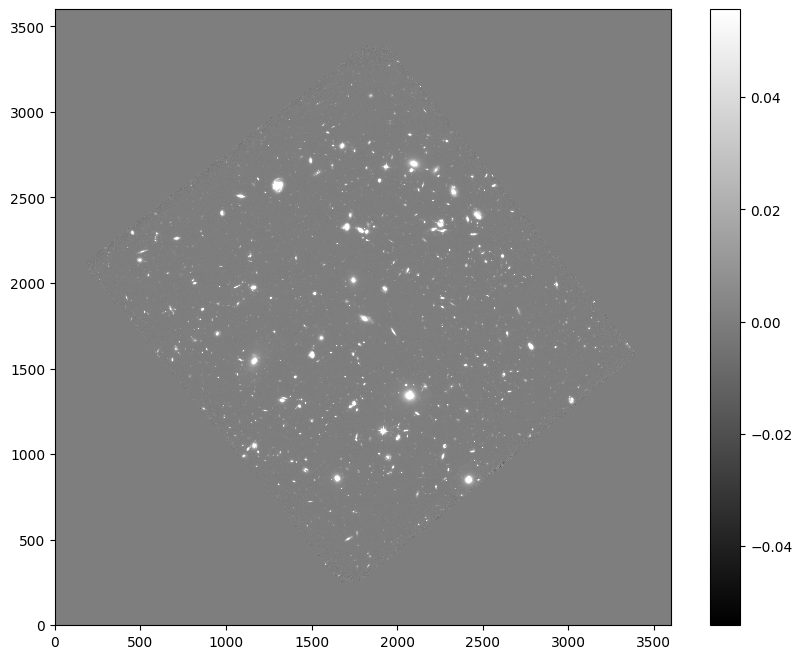

In [1]:
import numpy as np
import sep
from astropy.io import fits 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse

rcParams['figure.figsize']=[10.,8.]

with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    data=hdul[0].data
m,s=np.mean(data),np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('original_image_of_105w.png')

background

0.0
0.0005398219218477607


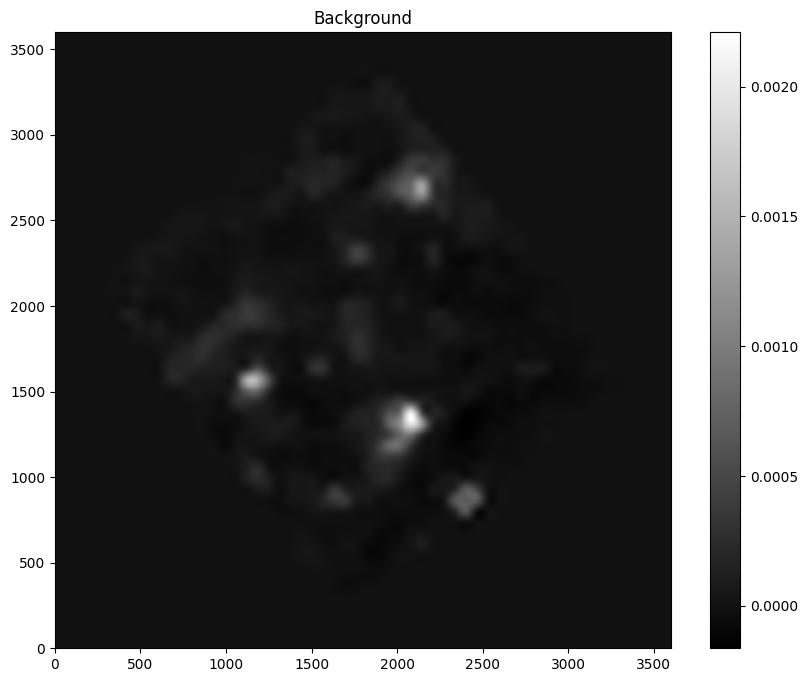

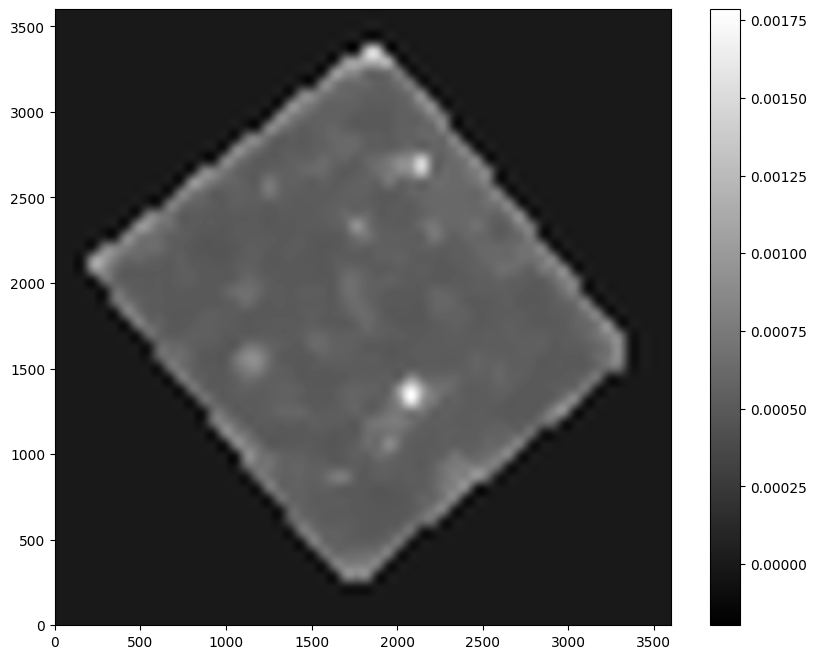

In [2]:
data = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)
print(bkg.globalback)  
print(bkg.globalrms)

bkg_image = bkg.back()
bkg_rms = bkg.rms()

plt.figure()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title('Background')
plt.savefig('background_105w.png')
plt.show()

bkg_rms=bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
data_sub=data-bkg
plt.savefig('background_rms_105w.png')

object detection

8643


('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

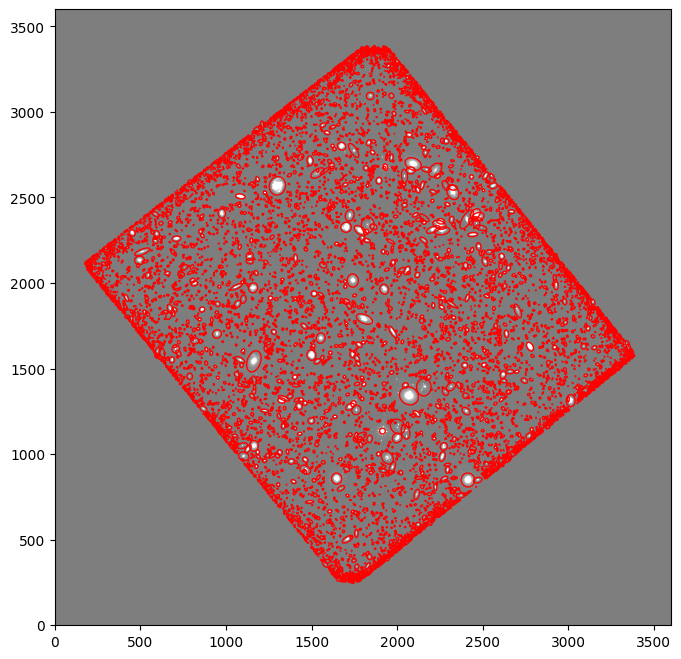

In [3]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects[i]['x'], objects[i]['y']),
                width=6*objects[i]['a'],
                height=6*objects[i]['b'],
                angle=objects[i]['theta'] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('detected_objects_105w.png')
print(len(objects))
objects.dtype.names

flux

In [4]:
flux,fluxerr,flag = sep.sum_circle(data_sub,objects['x'],objects['y'],3.0, err=bkg.globalrms, gain=1.0)
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


histogram

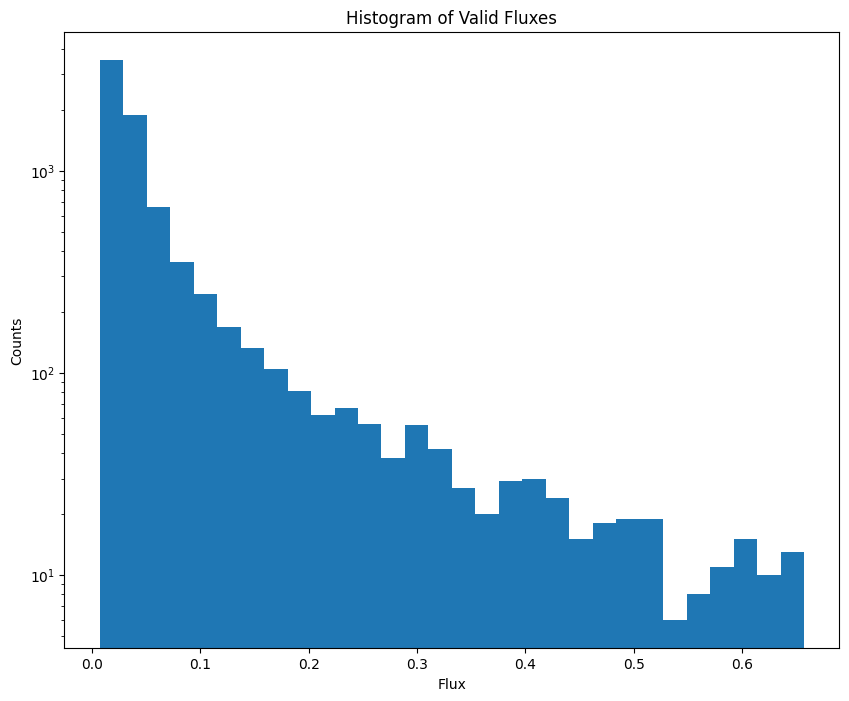

In [5]:
plt.hist(flux, bins=30, range=(np.percentile(flux, 5), np.percentile(flux, 95)))
plt.yscale('log')
plt.title('Histogram of Valid Fluxes')
plt.xlabel('Flux')
plt.ylabel('Counts')
plt.savefig('histogram_flux.png')
plt.show()


the mean, median, and standard deviation of the distribution of fluxes
the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean

In [6]:

mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)
print("Mean flux: ",mean_flux)
print("Median flux: ",median_flux)
print("Standard deviation of flux:",std_flux)


outlier_flux = np.max(flux)
outlier_index = np.argmax(flux)
outlier_position = (objects['x'][outlier_index], objects['y'][outlier_index])
outlier_std= (outlier_flux-mean_flux)/std_flux
print("Largest outlier flux: ",outlier_flux)
print("Outlier position (x, y): ",outlier_position)
print(f"Outlier is {outlier_std:.2f} standard deviations from the mean")


Mean flux:  0.36174662582932254
Median flux:  0.030954822918865834
Standard deviation of flux: 9.24192555585277
Largest outlier flux:  807.2972835731507
Outlier position (x, y):  (1914.2549094866436, 1134.3164850725645)
Outlier is 87.31 standard deviations from the mean


In [7]:
def scale_data(data, scale_min=None, scale_max=None): #scale it to make the picture mire clearly
    if scale_min is None:
        scale_min = np.percentile(data, 5)
    if scale_max is None:
        scale_max = np.percentile(data, 95)
    data_scaled = np.clip(data, scale_min, scale_max)
    data_scaled = (data_scaled - scale_min)/(scale_max - scale_min)
    data_scaled = np.log10(data_scaled + 1)/np.log10(data_scaled.max() + 1)
    return data_scaled

f105w_data = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits', ext=0)
f125w_data = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits', ext=0)
f160w_data = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits', ext=0)

scaled_f105w = scale_data(f105w_data)
scaled_f125w = scale_data(f125w_data)
scaled_f160w = scale_data(f160w_data)

rgb_image = np.zeros((f105w_data.shape[0],f105w_data.shape[1],3),dtype=float)
 
rgb_image[..., 0] = scaled_f160w
rgb_image[..., 1] = scaled_f125w 
rgb_image[..., 2] = scaled_f105w 

plt.imsave('hudf_rgb.png', rgb_image, dpi=300)
